# Tune GPT2 to generate controlled sentiment reviews
> Optimise GPT2 to produce IMDB movie reviews with controlled sentiment using a BERT sentiment classifier for rewards.

> warning: This notebook uses version `trl==0.0.3`.

<div style="text-align: center">
<img src='https://huggingface.co/datasets/trl-internal-testing/example-images/resolve/main/images/gpt2-ctrl-training-setup.png' width='600'>
<p style="text-align: center;"> <b>Figure:</b> Experiment setup to tune GPT2. The yellow arrows are outside the scope of this notebook, but the trained models are available through Hugging Face. </p>
</div>


The experiment setup is very similar to the positive sentiment notebook. However, in this notebook we fine-tune GPT2 (small) to generate **controlled** movie reviews based on the IMDB dataset. The model gets the target sentiment and 5 tokens from a real review and is tasked to produce continuations with the targeted sentiment. The reward for the continuations is calculated with the logits of a BERT sentiment classifier. That reward is then used for PPO training.

## Setup experiment

### Import dependencies

In [3]:
%load_ext autoreload
%autoreload 2

In [32]:
import torch
import wandb
import time
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from random import choices
import matplotlib.pyplot as plt
tqdm.pandas()

from datasets import load_dataset

from transformers import GPT2Tokenizer
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from trl.models import AutoModelForCausalLMWithValueHead
from trl.trainer import PPOTrainer, PPOConfig
from trl.core import build_bert_batch_from_txt, respond_to_batch

### Configuration

In [8]:
config = {
    "lm_name": "lvwerra/gpt2-imdb",
    "ref_lm_name": "lvwerra/gpt2-imdb",
    "cls_model_name": "lvwerra/distilbert-imdb",
    "tk_name": "gpt2",
    "steps": 51200,
    "batch_size": 256,
    "forward_batch_size": 16,
    "ppo_epochs": 4,   
    "txt_in_len": 5,
    "txt_out_len": 20,
    "lr": 1.41e-5,
    "init_kl_coef":0.2,
    "target": 6,
    "horizon":10000,
    "gamma":1,
    "lam":0.95,
    "cliprange": .2,
    "cliprange_value":.2,
    "vf_coef":.1, 
    "seed": 1,
}

In [9]:
np.random.seed(config['seed'])

You can see that we load a GPT2 model called `gpt2_imdb`. This model was additionally fine-tuned on the IMDB dataset for 1 epoch with the huggingface [script](https://github.com/huggingface/transformers/blob/master/examples/run_language_modeling.py) (no special settings). The other parameters are mostly taken from the original paper ["Fine-Tuning Language Models from Human Preferences"](
https://arxiv.org/pdf/1909.08593.pdf). This model as well as the BERT model is available in the Huggingface model zoo [here](https://huggingface.co/models). The following code should automatically download the models.

### Initialize W&B logger
We use `wandb`to log all the metrics during training.

In [10]:
wandb.init(name='long-response', project='gpt2-ctrl', config=config)

wandb: Currently logged in as: myfatemi. Use `wandb login --relogin` to force relogin


## Load data and models

### Load IMDB dataset
The IMDB dataset contains 50k movie review annotated with "positive"/"negative" feedback indicating the sentiment.  We load the IMDB dataset into a DataFrame and filter for comments that are at least 500 characters long and take the first 1000 characters of each comment. The first filter we apply to avoid comments that are less than `txt_in_len` token long and the second to avoid tokenizing way more text than we actually need.

In [11]:
# load imdb with datasets
ds = load_dataset('imdb', split='train')
ds = ds.rename_columns({'text': 'review', 'label': 'sentiment'})
ds.set_format('pandas')
df = ds[:]

# make sure the comments are long enough
df = df.loc[df['review'].str.len() > 500]

# make sure comments are not too long
df['review'] = df['review'].apply(lambda x: x[:1000])

df.head()

Found cached dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


,review,sentiment
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


### Load BERT classifier
We load a BERT classifier fine-tuned on the IMDB dataset.

In [12]:
sentiment_model = AutoModelForSequenceClassification.from_pretrained(config["cls_model_name"])
sentiment_tokenizer = AutoTokenizer.from_pretrained(config["cls_model_name"])

The model outputs are the logits for the negative and positive class. We will use the logits for positive class as a reward signal for the language model.

In [13]:
text = 'this movie was really bad!!'
output = sentiment_model.forward(sentiment_tokenizer.encode(text, return_tensors="pt"))
output

SequenceClassifierOutput(loss=None, logits=tensor([[ 2.3350, -2.7266]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [14]:
text = 'this movie was really good!!'
output = sentiment_model.forward(sentiment_tokenizer.encode(text, return_tensors="pt"))
output

SequenceClassifierOutput(loss=None, logits=tensor([[-2.2948,  2.5570]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [15]:
text = 'this movie was a documentary'
output = sentiment_model.forward(sentiment_tokenizer.encode(text, return_tensors="pt"))
output

SequenceClassifierOutput(loss=None, logits=tensor([[-0.7086,  0.8563]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

The resulting reward signal:

In [16]:
output[0][0, 1]

tensor(0.8563, grad_fn=<SelectBackward0>)

### Load pre-trained GPT2 language models

We load the GPT2 model with a value head and the tokenizer. We load the model twice; the first model is optimized while the second model serves as a reference to calculate the KL-divergence from the starting point. This serves as an additional reward signal in the PPO training to make sure the optimized model does not deviate too much from the original language model.

In [18]:
gpt2_model = AutoModelForCausalLMWithValueHead.from_pretrained(config['lm_name'])
gpt2_model_ref = AutoModelForCausalLMWithValueHead.from_pretrained(config['ref_lm_name'])
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(config['tk_name'])

### Move models to GPU

If `cuda` is available move the computations to the GPU.

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
_ = gpt2_model.to(device)
_ = sentiment_model.to(device)
_ = gpt2_model_ref.to(device)

### Watch model with wandb
This wandb magic logs the gradients and weights of the model during training.

In [21]:
wandb.watch(gpt2_model, log='all')

[]

### Tokenize IMDB reviews

We tokenize all IMDB in advance to avoid tokenizing twice. In the first step we encode the queries and slice the first `txt_in_len` tokens. In a second step we decode these tokens back to text for later display.

In [22]:
df['tokens'] = df['review'].progress_apply(lambda x: gpt2_tokenizer.encode(' '+x, return_tensors="pt").to(device)[0, :config['txt_in_len']])

100%|██████████| 22578/22578 [00:30<00:00, 740.57it/s]


In [23]:
df['query'] = df['tokens'].progress_apply(lambda x: gpt2_tokenizer.decode(x))

100%|██████████| 22578/22578 [00:00<00:00, 32664.26it/s]


### Control token dict
We will append the control token at the beginning of each query to signal the model what the target sentiment is. Each control sequence consists of three tokens:

In [24]:
ctrl_str = ['[negative]', '[neutral]', '[positive]']

ctrl_tokens = dict((s, gpt2_tokenizer.encode(s, return_tensors="pt").squeeze().to(device)) for s in ctrl_str)

In [25]:
ctrl_tokens

{'[negative]': tensor([   58, 31591,    60], device='cuda:0'),
 '[neutral]': tensor([   58, 29797,    60], device='cuda:0'),
 '[positive]': tensor([   58, 24561,    60], device='cuda:0')}

### Reward function

In [26]:
def pos_logit_to_reward(logit, task):
    """
    Take the positive sentiment logit and scale it for the task.
        task [negative]: reward = -logit
        task [neutral]: reward = -2*abs(logit)+4
        task [positive]: reward = logit
    """
    for i in range(len(logit)):
        if task[i]=='[negative]':
            logit[i] = -logit[i]
        elif task[i]=='[neutral]':
            logit[i] = -2*torch.abs(logit[i])+4
        elif task[i]=='[positive]':
            pass
        else:
            raise ValueError('task has to be in [0, 1, 2]!')
    return logit

The following examples show the rewards for the cases where the classifier logit is 4, -4 and 0 for the three targets `['negative]`, `['neutral]` and `['positive']`. The scaling is not perfect as it differs between neutral and the other two classes. This is something to further investigate in the future. Ideally, one would use the logit output for each class individually, but since there is no dedicated class for neutral this is a workaround.

In [27]:
print(ctrl_str)

['[negative]', '[neutral]', '[positive]']


In [28]:
pos_logit_to_reward(torch.Tensor([4,4,4]), ctrl_str)

tensor([-4., -4.,  4.])

In [29]:
pos_logit_to_reward(torch.Tensor([-4,-4,-4]), ctrl_str)

tensor([ 4., -4., -4.])

In [30]:
pos_logit_to_reward(torch.Tensor([0, 0, 0]), ctrl_str)

tensor([-0., 4., 0.])

## Optimize model

**Steps**

The training loop consists of the following steps:
1. Get a batch of queries and create random controls
2. Get the query responses from the policy
3. Join query and responses and tokenize for BERT analysis
4. Get sentiments for query/responses from BERT
5. Optimize policy with PPO using the (query, response, reward) triplet
6. Log all the training statistics

**Forward batching**

Since the models can be fairly big and we want to rollout large PPO batches this can lead to out-of-memory errors when doing the forward passes for text generation and sentiment analysis. We introduce the parameter `forward_batch_size` to split the forward passes into smaller batches. Although this hurts performance a little this is neglectible compared to the computations of the backward passes when optimizing the model. The same parameter is used in the `PPOTrainer` when doing forward passes. The `batch_size` should multiple of `forward_batch_size`.

**Training time**

This step takes **~2h** on a P6000 GPU with the above specified settings.

In [33]:
config

{'lm_name': 'lvwerra/gpt2-imdb',
 'ref_lm_name': 'lvwerra/gpt2-imdb',
 'cls_model_name': 'lvwerra/distilbert-imdb',
 'tk_name': 'gpt2',
 'steps': 51200,
 'batch_size': 256,
 'forward_batch_size': 16,
 'ppo_epochs': 4,
 'txt_in_len': 5,
 'txt_out_len': 20,
 'lr': 1.41e-05,
 'init_kl_coef': 0.2,
 'target': 6,
 'horizon': 10000,
 'gamma': 1,
 'lam': 0.95,
 'cliprange': 0.2,
 'cliprange_value': 0.2,
 'vf_coef': 0.1,
 'seed': 1}

In [35]:
# Create PPO config
config_ppo = PPOConfig(
    model_name='lvwerra/gpt2-imdb',
    steps=51200,
    learning_rate=1.41e-05,
    adap_kl_ctrl=True,
    init_kl_coef=0.2,
    horizon=10000,
    gamma=1,
    lam=0.95,
    cliprange=0.2,
    cliprange_value=0.2,
    vf_coef=0.1,
    batch_size=256,
    forward_batch_size=16,
    ppo_epochs=4,
    remove_unused_columns=True,
    log_with_wandb=True,
    wandb_project='gpt2-ctrl'
)

In [39]:
df.sample(10)['tokens'].tolist()

[tensor([8920,   77,  470, 2407, 1654], device='cuda:0'),
 tensor([11136,   717,  8793, 16117,   351], device='cuda:0'),
 tensor([  854,   441, 10185,   314,  1392], device='cuda:0'),
 tensor([1002,  428, 3807,  373, 3194], device='cuda:0'),
 tensor([9576, 1178,  523, 1444,  366], device='cuda:0'),
 tensor([ 314, 1183,  307, 5508,   13], device='cuda:0'),
 tensor([2644,  770, 2125,  470,  262], device='cuda:0'),
 tensor([4452,  670,   11, 2592,  287], device='cuda:0'),
 tensor([ 314, 6635, 4236,  326,  366], device='cuda:0'),
 tensor([45437,   338,  5542,    25,   383], device='cuda:0')]

In [45]:
import gc

gc.collect()

157

In [46]:
ppo_trainer = PPOTrainer(config_ppo, gpt2_model, gpt2_model_ref, gpt2_tokenizer)
fbs = config_ppo.forward_batch_size
bs = config_ppo.batch_size

batch_count = int(np.ceil(config_ppo.steps/config_ppo.batch_size))

for epoch in tqdm(range(batch_count)):
    torch.cuda.empty_cache()
    logs = dict()
    game_data = dict()
    timing = dict()
    t0 = time.time()
    
    #### get a batch from the dataset and annotate tasks.
    #### these tasks are chosen randomly, and the reward
    #### is calculated based on the strength of the match.
    df_batch = df.sample(bs)
    task_list = choices(ctrl_str, k=bs)
    task_tensors = torch.stack([ctrl_tokens[t] for t in task_list])
    query_list = df_batch['query'].tolist()
    game_data['query'] = [t+q for t,q in zip(task_list, query_list)]
    
    query_tensors = torch.stack(df_batch['tokens'].tolist())
    query_tensors = torch.cat((task_tensors, query_tensors), axis=1)
    
    #### get response from gpt2. these include the task
    #### specifiers. GPT2's reward is how well the completion
    #### matches with the desired task. The match with the desired
    #### task is calculated with automated means (DistilBERT fine-tuned
    #### on IMDb)
    t = time.time()
    response_tensors = torch.cat([
        respond_to_batch(
            gpt2_model,
            query_tensors[i*fbs:(i+1)*fbs],
            txt_len=config['txt_out_len']
        )
        for i in range(int(bs/fbs))
    ])
    game_data['response'] = [gpt2_tokenizer.decode(response_tensors[i, :]) for i in range(config['batch_size'])]
    timing['time/get_response'] = time.time()-t

    #### tokenize text for sentiment analysis
    t = time.time()
    texts = [q + r for q,r in zip(query_list, game_data['response'])]
    sentiment_inputs, attention_masks = build_bert_batch_from_txt(texts, sentiment_tokenizer, device)    
    timing['time/build_input_sentiment'] = time.time()-t

    #### get sentiment score
    t = time.time()
    pos_logits = torch.cat([
        sentiment_model.forward(
            sentiment_inputs[i*fbs:(i+1)*fbs],
            attention_masks[i*fbs:(i+1)*fbs]
        )[0][:, 1].detach()
        for i in range(int(bs/fbs))
    ])
    rewards = pos_logit_to_reward(pos_logits, task_list)
    timing['time/get_sentiment_preds'] = time.time()-t

    #### Run PPO training
    #### Given some query tensors, response tensors, and rewards:
    #### 
    t = time.time()
    stats = ppo_trainer.step(list(query_tensors), list(response_tensors), list(rewards))
    timing['time/optimization'] = time.time()-t
     
    #### Log everything
    timing['time/epoch'] = time.time()-t0
    table_rows = [list(r) for r in zip(game_data['query'], game_data['response'], rewards.cpu().tolist())]
    logs.update({'game_log':wandb.Table(
        columns=['query', 'response', 'reward'],
        rows=table_rows)})
    logs.update(timing)
    logs.update(stats)
    logs['env/reward_mean'] = torch.mean(rewards).cpu().numpy()
    logs['env/reward_std'] = torch.std(rewards).cpu().numpy()
    logs['env/reward_dist'] = rewards.cpu().numpy()
    for ctrl_s in ctrl_str:
        key = 'env/reward_'+ctrl_s.strip('[]')
        logs[key] = np.mean([r for r, t in zip(logs['env/reward_dist'], task_list) if t==ctrl_s])
    wandb.log(logs)

100%|██████████| 200/200 [4:09:58<00:00, 74.99s/it]


### Training progress
If you are tracking the training progress with Weights&Biases you should see a plot similar to the following:

<div style="text-align: center">
<img src='https://huggingface.co/datasets/trl-internal-testing/example-images/resolve/main/images/gpt2-ctrl-training-stats.png' width='800'>
<p style="text-align: center;"> <b>Figure:</b> Reward mean and distribution evolution during training. </p>
</div>

One can observe how the model starts to generate more positive outputs after a few optimisation steps.

> Note: Investigating the KL-divergence will probably show that at this point the model has not converged to the target KL-divergence, yet. To get there would require longer training or starting with a higher inital coefficient.

## Model inspection

### Reward distribution
First, we can have a look at the reward distribution. Both the negative and positive rewards are clearly shifted to high rewards. The neutral rewards, however, are still centered around zero. There are a few possible explanations for this. There could be a bug in the code and the way the neutral rewards are calculated. Another problem could be that sentence sometimes start with a strong sentiment and it is hard for the model shift the sentiment towards neutral.

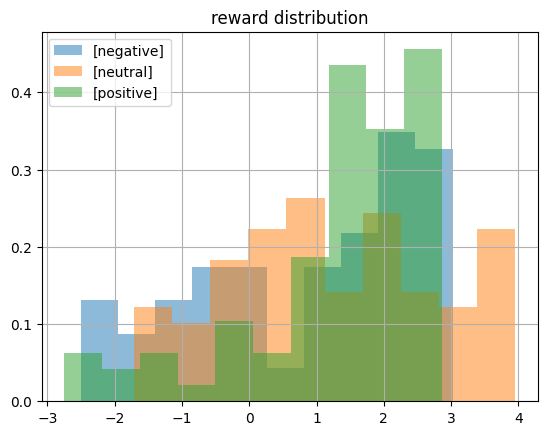

In [47]:
for ctrl_s in ctrl_str:
    plt.hist([r for r, t in zip(logs['env/reward_dist'], task_list) if t==ctrl_s],
             density=True,
             alpha=0.5,
             label=ctrl_s)
plt.legend(loc='best')
plt.title('reward distribution')
plt.grid(True)
plt.show()

### Examples

In [48]:
#### get a batch from the dataset
bs = 32
game_data = dict()
df_batch = df.sample(bs)
query_list = df_batch['query'].tolist()
game_data['query'] = query_list
for ctrl in ctrl_str:
    task_list = [ctrl] * bs
    task_tensors = torch.stack([ctrl_tokens[t] for t in task_list])

    query_tensors = torch.stack(df_batch['tokens'].tolist())
    query_tensors = torch.cat((task_tensors, query_tensors), axis=1)

    #### get response from gpt2 and gpt2_ref
    response_tensors  = respond_to_batch(gpt2_model, query_tensors, txt_len=config['txt_out_len'])
    game_data['response ' + ctrl] = [gpt2_tokenizer.decode(response_tensors[i, :]) for i in range(bs)]

    #### sentiment analysis of query/response pairs before/after
    texts = [q + r for q,r in zip(game_data['query'], game_data['response ' + ctrl])]
    sentiment_inputs, attention_masks = build_bert_batch_from_txt(texts, sentiment_tokenizer, device)    
    rewards = sentiment_model.forward(sentiment_inputs, attention_masks)[0][:, 1].detach()
    game_data['rewards ' + ctrl] = pos_logit_to_reward(rewards, task_list).cpu().numpy()

# store results in a dataframe
df_results = pd.DataFrame(game_data)
df_results

,query,response [negative],rewards [negative],response [neutral],rewards [neutral],response [positive],rewards [positive]
0,A Classic Hollywood Biopic,. I couldn't believe I had actually seen the m...,-0.127471,is a little bit hoarded. The normal Hollywood...,3.943662,". If you like things todo, I don't have the se...",0.976845
1,I saw this film at,university. I was taken with little more than...,1.451300,the age of nine to make illustrations of the ...,3.736063,"first, and I actually liked it. And to see an...",2.494144
2,this movie is awesome.,<|endoftext|> I'm surprised at how much people...,-2.593433,"The acting is so good, the assembly is so stu...",0.303356,It's nice of the script. This is one of those...,2.697313
3,I'll give this movie,4 out of 10.<|endoftext|> This is very frustr...,2.612106,an 8. I think this is one of the best movies ...,-0.810928,4 because it is a masterpiece. This is one of...,2.810789
4,When robot hordes start attacking,"mankind, you get scared because they have the...",0.752720,you. The best thing you can do is be sure to ...,2.600171,"humans, only they don´t because of a bizarre ...",-0.993947
5,I disagree strongly with anyone,who believes this film is fundamentally bad. ...,2.410846,who believes thatya can express legally immac...,1.299608,"who can read the book, and I understand the p...",0.985047
6,I saw this film about,"2 years ago when I first saw it, and I had to...",-1.267393,"the Friday the 13th,, today he gets it wrong....",2.987020,"20 years ago, but it's a page lot more. The D...",1.653561
7,The story is extremely unique,but I'm afraid I had all my nerve as a larval...,-0.410321,", and an concept is fitting. Government and th...",-1.267241,and the direction is perfect. The songs are t...,2.790290
8,I'm not a huge,"fan objectors, here at least was totally igno...",1.295485,fan of theGame. The arcade games are bad.2<|e...,0.029579,"fan of Ann either, but I did not like it. I t...",0.278986
9,The Secret of Kells,of Woolhop's bankruptcy and before him left f...,-0.078557,"has been revealed in the order of this film, ...",3.301053,""" is giving a replay of the regular run-of-the...",2.713490


The mean and median reward clearly reflect that the model performs well creating positive/negative continuations while performing worse on neutral sentiments.

In [49]:
print('mean:')
display(df_results.mean())
print()
print('median:')
display(df_results.median())

mean:


/tmp/ipykernel_8817/1253268971.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  display(df_results.mean())


rewards [negative]    0.654782
rewards [neutral]     1.583745
rewards [positive]    1.512459
dtype: float32


median:


/tmp/ipykernel_8817/1253268971.py:5: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  display(df_results.median())


rewards [negative]    0.766043
rewards [neutral]     1.670244
rewards [positive]    1.774114
dtype: float32

In [ ]:
print('mean:')
display(df_results.mean())
print()
print('median:')
display(df_results.median())

mean:


rewards [negative]    2.074598
rewards [neutral]    -0.054790
rewards [positive]    2.893329
dtype: float64


median:


rewards [negative]    2.853347
rewards [neutral]     0.071524
rewards [positive]    3.779774
dtype: float64

### Controlled continuation

In [50]:
input_string = '[negative] The movie'
input_tokens = gpt2_tokenizer.encode(input_string, return_tensors="pt").to(device)

response_tensors = respond_to_batch(gpt2_model, input_tokens, txt_len=config['txt_out_len'])
response_strings = gpt2_tokenizer.decode(response_tensors[0, :])
response_strings

' is so bad that I do not pick it up after seeing this movie. We would even go in'

In [51]:
input_string = '[neutral] The movie'
input_tokens = gpt2_tokenizer.encode(input_string, return_tensors="pt").to(device)

response_tensors = respond_to_batch(gpt2_model, input_tokens, txt_len=config['txt_out_len'])
response_strings = gpt2_tokenizer.decode(response_tensors[0, :])
response_strings

' seemed to show us how cultural and worldly American multiplies are similar to American lives. The childhood consumed'

In [52]:
input_string = '[positive] The movie'
input_tokens = gpt2_tokenizer.encode(input_string, return_tensors="pt").to(device)

response_tensors = respond_to_batch(gpt2_model, input_tokens, txt_len=config['txt_out_len'])
response_strings = gpt2_tokenizer.decode(response_tensors[0, :])
response_strings

' is worth checking out, even if you are interested in escapist novelty.<|endoftext|> This is an entertaining'

### Mixed continuation

In [53]:
input_string = '[negative] The movie'
input_tokens = gpt2_tokenizer.encode(input_string, return_tensors="pt").to(device)

response_tensors = respond_to_batch(gpt2_model, input_tokens, txt_len=config['txt_out_len'])
response_strings = gpt2_tokenizer.decode(response_tensors[0, :])
response_strings

" was terrible.personal not into it, for God's sake. But when you do a good job"

In [54]:
input_string = '[positive] The movie'
input_string += " didn't really have a focus at all. No need to make obvious movies."
input_tokens = gpt2_tokenizer.encode(input_string, return_tensors="pt").to(device)

response_tensors = respond_to_batch(gpt2_model, input_tokens, txt_len=config['txt_out_len'])
response_strings = gpt2_tokenizer.decode(response_tensors[0, :])
response_strings

' # of course no one knew what was going on when someone was up to the top of your own'

## Save model
Finally, we save the model to disk for later usage.

In [55]:
#os.makedirs('gpt2-imdb-ctrl')
gpt2_model.save_pretrained('gpt2-imdb-ctrl')
gpt2_tokenizer.save_pretrained('gpt2-imdb-ctrl')

('gpt2-imdb-ctrl/tokenizer_config.json',
 'gpt2-imdb-ctrl/special_tokens_map.json',
 'gpt2-imdb-ctrl/vocab.json',
 'gpt2-imdb-ctrl/merges.txt',
 'gpt2-imdb-ctrl/added_tokens.json')